# Testing 

get going

In [76]:
data class Bla(val x1:Int, val y1:Int, val x2:Int, val y2:Int)

In [77]:
val b = Bla(0, 10, 100, 100)
println(b)

Bla(x1=0, y1=10, x2=100, y2=100)


Now lets draw something

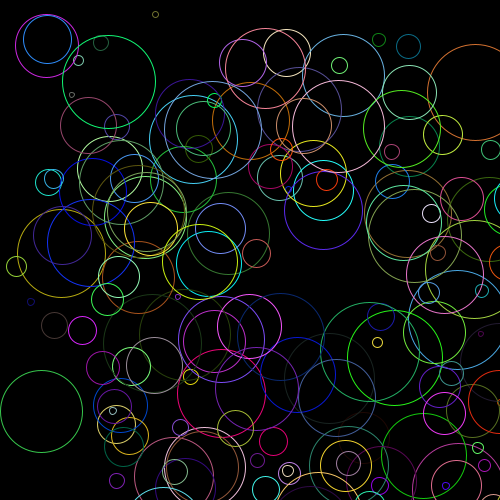

In [78]:
canvas(Size(500, 500)) { size ->
    background = Color.BLACK
    clearRect(0, 0, size.width, size.height)
    setRenderingHint(
        java.awt.RenderingHints.KEY_ANTIALIASING,
        java.awt.RenderingHints.VALUE_ANTIALIAS_ON
    )
    repeat(ovalCount) {
        color = randomColor()
        val radius = randomRadius()
        val center = randomOffset(size)
        drawOval(center.x, center.y, radius, radius)
    }
}

Change the ovalCount to increase or decrease how many scribbles we draw.

In [79]:
val ovalCount = 150

Let's try another one, like random flecks

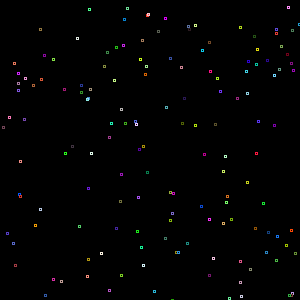

In [80]:
canvas {size ->
    background = Color.BLACK
    clearRect(0, 0, size.width, size.height)
    repeat(150) {
        color = randomColor()
        val p = randomOffset(size)
        drawRect(p.x, p.y, 2, 2)
    }
}

Let's sprinkle sprinkle the flecks evenly

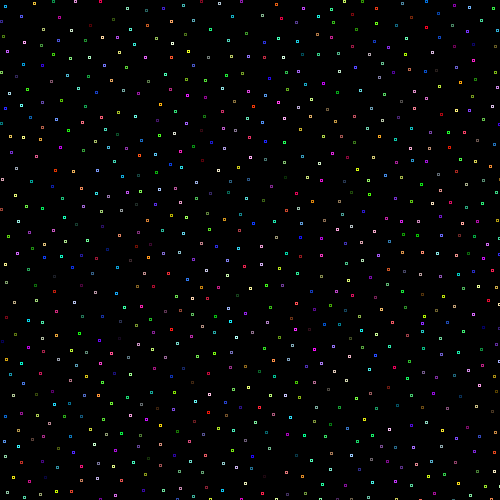

In [81]:
canvas(Size(500, 500)) { size ->
    background = Color.BLACK
    clearRect(0, 0, size.width, size.height)
    val stars = buildPoissonDiscPoints(size, 15f)
    for (s in stars) {
        color = randomColor()
        drawRect(s.x, s.y, 2, 2)
    }
}

# Behind the scenes

How about some functions to get some random values as well as a way to get points on a Poisson Disc distribution

In [82]:
import java.awt.Color
import kotlin.random.Random
import kotlin.math.*

fun randomColor(): Color {
    val colorRange = 0..255
    val r = colorRange.random()
    val g = colorRange.random()
    val b = colorRange.random()
    return Color(r, g, b)
}

fun randomGrey(): Color {
    val colorRange = 0..255
    val c = colorRange.random()
    return Color(c, c, c)
}
data class Point(val x:Int, val y:Int)
data class Size(val width:Int, val height:Int)
fun randomOffset(size: Size) =
    Point(
        x = Random.nextInt(0, size.width),
        y = Random.nextInt(0, size.height)
    )
   
fun randomRadius(min:Int = 5, max:Int = 100) = Random.nextInt(min, max)

class PoissonDisc(
    private val width: Float,
    private val height: Float,
    private val radius: Float,
    private val k: Int = 30
) {
    private val cellSize = radius / sqrt(2f)
    private val gridWidth = ceil(width / cellSize).toInt()
    private val gridHeight = ceil(height / cellSize).toInt()
    private val grid = Array(gridWidth * gridHeight) { -1 }
    private val points = mutableListOf<Pair<Float, Float>>()
    private val activePoints = mutableListOf<Pair<Float, Float>>()

    fun generatePoints(): List<Pair<Float, Float>> {
        val initialPoint = Pair(
            (random() * width).toFloat(),
            (random() * height).toFloat()
        )

        points.add(initialPoint)
        activePoints.add(initialPoint)

        while (activePoints.isNotEmpty()) {
            val activeIndex = (random() * activePoints.size).toInt()
            val activePoint = activePoints[activeIndex]

            var found = false
            for (i in 0 until k) {
                val newPoint = generateRandomPointAround(activePoint)

                if (newPoint.first < 0 || newPoint.first >= width ||
                    newPoint.second < 0 || newPoint.second >= height
                ) {
                    continue
                }

                val cellX = (newPoint.first / cellSize).toInt()
                val cellY = (newPoint.second / cellSize).toInt()

                var isValid = true

                for (dx in -1..1) {
                    for (dy in -1..1) {
                        val neighbourX = cellX + dx
                        val neighbourY = cellY + dy

                        if (neighbourX < 0 || neighbourX >= gridWidth ||
                            neighbourY < 0 || neighbourY >= gridHeight
                        ) {
                            continue
                        }

                        val neighbourIndex = neighbourY * gridWidth + neighbourX
                        val neighbour = grid[neighbourIndex]

                        if (neighbour != -1 && isTooClose(points[neighbour], newPoint)) {
                            isValid = false
                            break
                        }
                    }

                    if (!isValid) break
                }

                if (isValid) {
                    points.add(newPoint)
                    activePoints.add(newPoint)
                    grid[cellY * gridWidth + cellX] = points.lastIndex
                    found = true
                    break
                }
            }

            if (!found) {
                activePoints.removeAt(activeIndex)
            }
        }

        return points
    }

    private fun generateRandomPointAround(point: Pair<Float, Float>): Pair<Float, Float> {
        val angle = random() * 2 * PI.toFloat()
        val distance = radius + random() * radius

        val x = point.first + cos(angle) * distance
        val y = point.second + sin(angle) * distance

        return x.toFloat() to y.toFloat()
    }

    private fun isTooClose(pointA: Pair<Float, Float>, pointB: Pair<Float, Float>): Boolean {
        val dx = pointA.first - pointB.first
        val dy = pointA.second - pointB.second
        val distance = sqrt(dx * dx + dy * dy)

        return distance < radius
    }

    private fun random(): Double {
        return Random.nextDouble()
    }
}

fun buildPoissonDiscPoints(size: Size, radius: Float = 20f): List<Point> =
    PoissonDisc(size.width.toFloat(), size.height.toFloat(), radius)
        .generatePoints()
        .map { Point(it.first.toInt(), it.second.toInt()) }

In [83]:
import java.awt.Graphics2D
import java.awt.image.BufferedImage

fun canvas(
    size: Size = Size(300, 300),
    block: Graphics2D.(size: Size) -> Unit,
): BufferedImage {
    val image = BufferedImage(size.width, size.height, BufferedImage.TYPE_INT_ARGB)
    val graphics = image.createGraphics()
    with(graphics) {
        block(size)
    }
    graphics.dispose()
    return image
}